# Task 1 : Set up colab gpu runtime environment

In [97]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qjhq_61v
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qjhq_61v
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [98]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


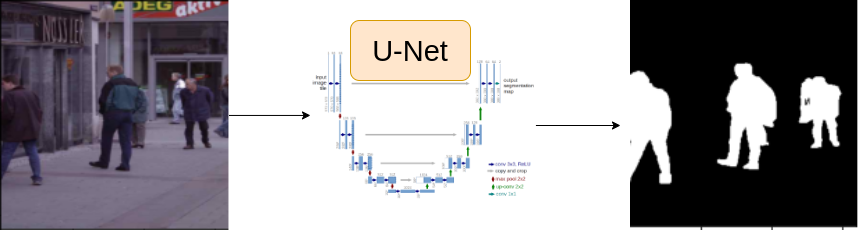

# Some Common Imports

In [99]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [100]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [101]:
csv_file ='/content/Human-Segmentation-Dataset-master/train.csv'
data_dir='/content/'

In [129]:
DEVICE = 'cuda'

In [103]:
epochs = 25
lr = 0.002
img_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'




In [104]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [105]:
row = df.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

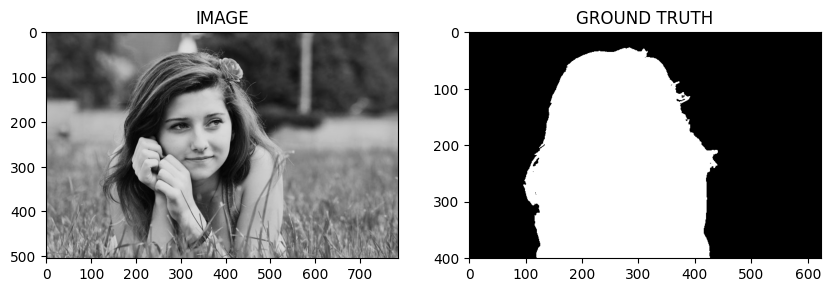

In [106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [107]:
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [108]:
import albumentations as  A

In [109]:
def get_train_augs():
  return A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),

  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(img_size, img_size),

  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [110]:

from torch.utils.data import Dataset

In [111]:
class SegmentationDataset(Dataset):

 def __init__(self, df, augmentations):

  self.df = df
  self.augmentations = augmentations

 def __len__(self):
  return len(self.df)

 def __getitem__(self, idx):

  row = self.df.iloc[idx]

  image_path = row.images
  mask_path = row.masks

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = np.expand_dims(mask, axis=-1)

  if self.augmentations:
    data = self.augmentations(image = image, mask = mask)
    image = data['image']
    mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask


In [112]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [113]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


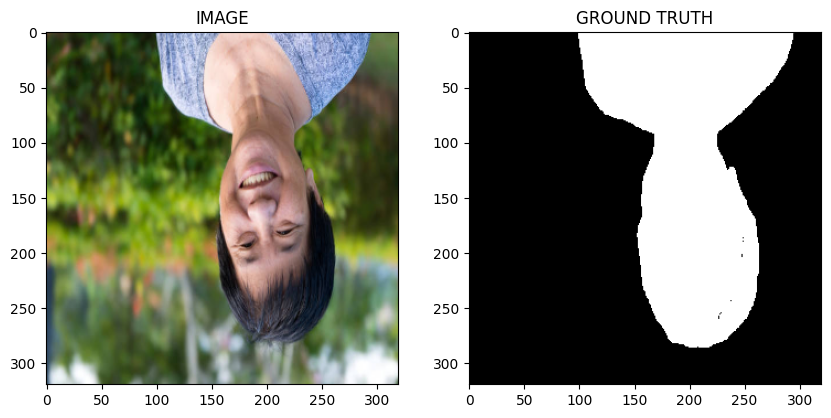

In [114]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [115]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle = True, )
validloader = DataLoader(validset, batch_size= batch_size)

In [116]:
from torch.utils.data import DataLoader

In [117]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [118]:
for image, mask in trainloader:
  break

print(f"one batch image shape :{image.shape}")
print(f"one batch mask shape :{mask.shape}")

one batch image shape :torch.Size([16, 3, 320, 320])
one batch mask shape :torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [120]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [176]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights= weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks !=None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# Task 7 : Create Train and Validation Function

In [181]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

     images = images.to(DEVICE)
     masks = masks.to(DEVICE)

     optimizer.zero_grad()
     logits, loss = model(images, masks)
     loss.backward()
     optimizer.step()

     total_loss += loss.item()

  return total_loss/ len(data_loader)


def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
      for images, masks in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        logits, loss = model(images, masks)

        total_loss += loss.item()

      return total_loss/ len(data_loader)

# Task 8 : Train Model

In [182]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [183]:
best_valid_loss = np.Inf

for i in range(epochs):

   train_loss = train_fn(trainloader, model, optimizer)
   valid_loss = eval_fn(validloader, model)

   if valid_loss < best_valid_loss:
     torch.save(model.state_dict(),'best_model.pt')
     print("SAVED MODEL")
     best_valid_loss = valid_loss

   print(f"Epoch: {i+1} Train Loss: (train_loss) Valis_loss: {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED MODEL
Epoch: 1 Train Loss: (train_loss) Valis_loss: 0.36063504964113235


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED MODEL
Epoch: 2 Train Loss: (train_loss) Valis_loss: 0.23424889519810677


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


SAVED MODEL
Epoch: 3 Train Loss: (train_loss) Valis_loss: 0.20144972950220108


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch: 4 Train Loss: (train_loss) Valis_loss: 0.2338758260011673


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch: 5 Train Loss: (train_loss) Valis_loss: 0.23746946454048157


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch: 6 Train Loss: (train_loss) Valis_loss: 0.2578089162707329


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED MODEL
Epoch: 7 Train Loss: (train_loss) Valis_loss: 0.18735218420624733


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED MODEL
Epoch: 8 Train Loss: (train_loss) Valis_loss: 0.16532907262444496


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 9 Train Loss: (train_loss) Valis_loss: 0.20033841580152512


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch: 10 Train Loss: (train_loss) Valis_loss: 0.19370273500680923


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 11 Train Loss: (train_loss) Valis_loss: 0.19824454188346863


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 12 Train Loss: (train_loss) Valis_loss: 0.18219619989395142


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch: 13 Train Loss: (train_loss) Valis_loss: 0.18012381717562675


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch: 14 Train Loss: (train_loss) Valis_loss: 0.1816070508211851


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Epoch: 15 Train Loss: (train_loss) Valis_loss: 0.23265234753489494


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch: 16 Train Loss: (train_loss) Valis_loss: 0.18631386756896973


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 17 Train Loss: (train_loss) Valis_loss: 0.24545473977923393


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch: 18 Train Loss: (train_loss) Valis_loss: 0.2034679614007473


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch: 19 Train Loss: (train_loss) Valis_loss: 0.18367867916822433


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


Epoch: 20 Train Loss: (train_loss) Valis_loss: 0.1795361042022705


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 21 Train Loss: (train_loss) Valis_loss: 0.23719510436058044


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 22 Train Loss: (train_loss) Valis_loss: 0.2529505454003811


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 23 Train Loss: (train_loss) Valis_loss: 0.18733573332428932


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch: 24 Train Loss: (train_loss) Valis_loss: 0.16725471802055836


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

Epoch: 25 Train Loss: (train_loss) Valis_loss: 0.17080383002758026


# Task 9 : Inference

In [187]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

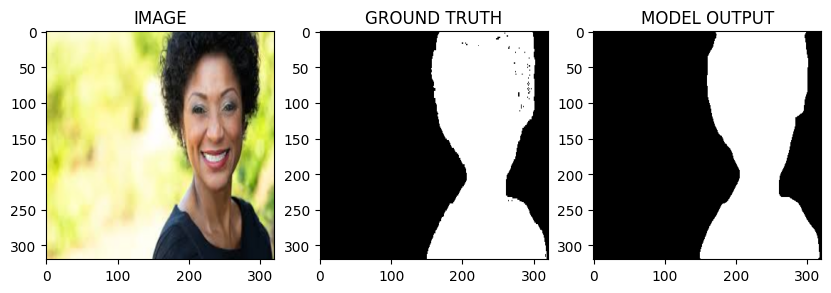

In [188]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya